# Projeto Final - Aprendizagem de Máquina
- Thiago Martin Poppe
- Matrícula: 2017014324

# Introdução ao dataset
- Para esse projeto, escolhi utilizar o dataset ``Traditional Food around the world`` presente no site [Kaggle](https://www.kaggle.com/abhijeetbhilare/world-cuisines). O dataset é formado por diversas imagens que demonstram pratos culinários tradicionais de diversas regiões do mundo, como por exemplo ``American``, ``European`` e ``Indian``.

# Objetivo e ideias
- O objetivo desse projeto é dado um prato determinar o país de origem do mesmo. Além dessa classificação, usaremos explicabilidade para tentar entender o motivo do modelo ter aprendido que um prato X pertence à região Y. Também iremos comparar diversas arquiteturas propostas para resolver o problema, como por exemplo MLP's, LeNet-5, entre outras.<br><br>

In [1]:
import os
import cv2

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from tqdm import tqdm

import warnings
warnings.filterwarnings("ignore") # filtering depricated warnings
np.random.seed(42) # fixing random seed to 42

# Definições de constantes

- Nessa célula definimos "constantes" que utilizaremos ao longo do notebook, como por exemplo: diretório raiz que contém as pastas com as imagens, as classes que usaremos, etc.

In [2]:
ROOT_DIR = "Dishes/"
IMG_SIZE = 224

N_CLASSES = 6
CLASSES = {
    "American": 0, "Chinese": 1,
    "European": 2, "Indian":  3,
    "Japanese": 4, "Korean":  5
}

# Funções de leitura e exibição de imagens

- A função de leitura utiliza a biblioteca ``OpenCv`` para ler, escalar e converter o mapeamento de cores para RGB, visto que, originalmente, a biblioteca lê a imagem com o mapeamento BGR (blue, green, red).<br><br>

- A função de exibição utiliza a biblioteca ``MatplotLib`` para exibir as imagens. Aqui não temos nada muito complexo, sendo apenas um "template" para criar subplots.

In [3]:
def read_img(filename, shape=(IMG_SIZE, IMG_SIZE)):
    """
        Helper function to read an image
        
        - Parameters:
            filename : string
            shape : tuple
        - Return:
            A RGB image
    """
    
    img = cv2.imread(filename)
    img = cv2.resize(img, shape, interpolation=cv2.INTER_AREA)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) # by default opencv uses BGR
    
    return np.array(img)

In [4]:
def plot_images(imgs, titles, rows, cols, cmap=None):
    """
        Helper function to plot/show images
        
        - Parameters:
            imgs   : List of images
            titles : List of strings
            rows   : Number of rows
            cols   : Number of columns
            cmap   : Grayscale, RGB, etc
    """
    
    fig, axs = plt.subplots(rows, cols, sharex=True, sharey=True)
    for i in range(rows):
        for j in range(cols):
            k = i*(rows+1) + j
            axs[i,j].set_title(titles[k])
            axs[i,j].imshow(imgs[k], cmap=cmap)

    fig.show()

# Representação one-hot vector
- A representação one-hot consiste em termos um vetor composto por 0's e apenas uma posição com valor 1. Utilizamos esse artifício para representar cada classe do nosso dataset.<br><br>

- Em um mundo ideal, queremos que a classificação tenha 100% de certeza, i.e que a resposta do classificador seja um vetor contendo apenas um valor 1 e os demais 0. Porém, na prática, isso não irá ocorrer sempre.

In [5]:
def one_hot(label):
    """
        Helper function that creates an one-hot vector given label
        
        - Parameters:
            label: string
            
        - Return:
            An one-hot vector
    """
    
    return np.eye(N_CLASSES)[CLASSES[label]]

In [6]:
for label in CLASSES:
    print(f"Class {label} will be seen as {one_hot(label)}")

Class American will be seen as [1. 0. 0. 0. 0. 0.]
Class Chinese will be seen as [0. 1. 0. 0. 0. 0.]
Class European will be seen as [0. 0. 1. 0. 0. 0.]
Class Indian will be seen as [0. 0. 0. 1. 0. 0.]
Class Japanese will be seen as [0. 0. 0. 0. 1. 0.]
Class Korean will be seen as [0. 0. 0. 0. 0. 1.]


# Leitura dos dados
- Nessa célula realizamos a leitura dos dados. Cada classe possui sua própria pasta contendo as imagens relacionadas com a comida tradicional da região.<br><br>

- Após a leitura e armazenamento de todos os dados em um DataFrame do ``pandas`` nós realizamos um shuffle para não termos futuros problemas com o aprendizado.

In [7]:
imgs = []
labels = []
    
for label in CLASSES:
    print(f"Loading {label} dishes...")        
    path = os.path.join(ROOT_DIR, label)
    for f in tqdm(os.listdir(path)):
        filename = os.path.join(path, f)

        try: # some images may be corrupted
            imgs.append(read_img(filename))
            labels.append(label)

        except Expection as E:
            print(str(E))

df = pd.DataFrame({"Dishes": imgs, "Region": labels})
df = df.sample(frac=1).reset_index(drop=True)

  3%|██▍                                                                            | 55/1815 [00:00<00:03, 548.75it/s]

Loading American dishes...


  2%|█▋                                                                             | 63/3030 [00:00<00:04, 620.14it/s]

Loading Chinese dishes...


  3%|██                                                                             | 51/1994 [00:00<00:03, 509.03it/s]

Loading European dishes...


  3%|██▏                                                                            | 66/2453 [00:00<00:03, 658.74it/s]

Loading Indian dishes...


  3%|██▎                                                                            | 62/2065 [00:00<00:03, 616.65it/s]

Loading Japanese dishes...


  5%|███▋                                                                          | 116/2422 [00:00<00:03, 582.13it/s]

Loading Korean dishes...


100%|█████████████████████████████████████████████████████████████████████████████| 2422/2422 [00:04<00:00, 597.84it/s]


# Balanceamento de classes

- Como podemos ver, temos uma distribuição balanceada das classes exceto pela chinesa. A maior diferença de dados se encontra entre as classes ``American`` e ``Chinese``, onde a segunda possui $\approx 1,67$ vezes mais imagens que a primeira.

<AxesSubplot:>

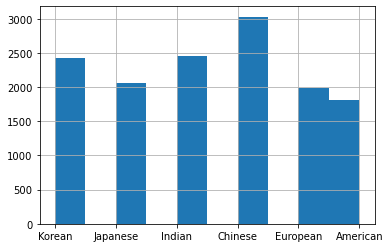

In [8]:
df["Region"].hist()

In [9]:
n_american = len(df[df["Region"] == "American"].index)
n_chinese  = len(df[df["Region"] == "Chinese"].index)

n_chinese / n_american

1.6694214876033058

# Algumas imagens

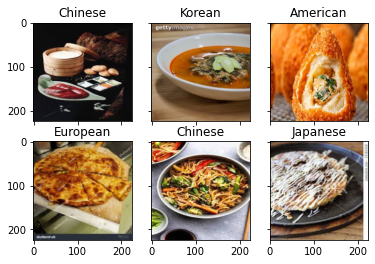

In [10]:
imgs = []
titles = []

for i in [32, 64, 90, 128, 140, 150]:
    imgs.append(df["Dishes"][i])
    titles.append(df["Region"][i])

plot_images(imgs, titles, rows=2, cols=3)